346/346 ━━━━━━━━━━━━━━━━━━━━ 442s 1s/step


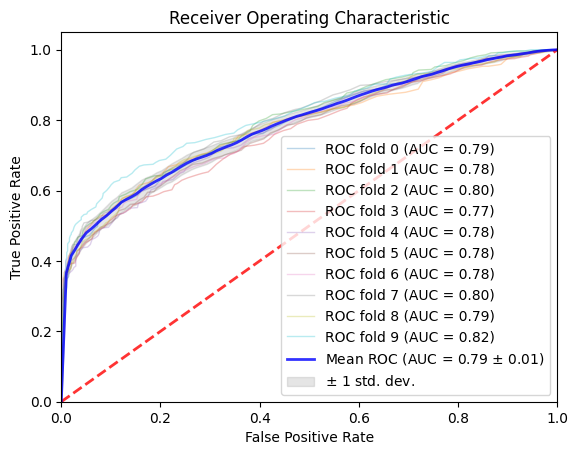

In [2]:
import numpy as np
import scipy.io as sio
from scipy.stats import kurtosis, skew
from scipy.signal import welch
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, roc_curve, auc, make_scorer
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Reshape, LSTM
import optuna
import pywt
from xgboost import XGBClassifier  # Make sure to import XGBClassifier

# Load the data
file_path = 'C:\\Users\\UC\\Documents\\NeuMa\\22117124\\new.mat'
new = sio.loadmat(file_path)
Label = new['label_list'].flatten()
EEG = new['EEG']

# Feature extraction for ML
def extract_ml_features(data):
    features = []
    for i in range(data.shape[2]):  # Iterate over samples
        sample = data[:, :, i]
        sample_features = []
        for j in range(data.shape[0]):  # Iterate over channels
            channel_data = sample[j, :]
            # Statistical features
            mean = np.mean(channel_data)
            var = np.var(channel_data)
            skewness = skew(channel_data)
            kurt = kurtosis(channel_data)
            # Frequency domain features using Welch's method
            freqs, psd = welch(channel_data)
            psd_mean = np.mean(psd)
            psd_std = np.std(psd)
            # Combine all features
            sample_features.extend([mean, var, skewness, kurt, psd_mean, psd_std])
        features.append(sample_features)
    return np.array(features)

# Wavelet transform features
def extract_wavelet_features(data):
    features = []
    for i in range(data.shape[2]):  # Iterate over samples
        sample = data[:, :, i]
        sample_features = []
        for j in range(data.shape[0]):  # Iterate over channels
            channel_data = sample[j, :]
            coeffs = pywt.wavedec(channel_data, 'db4', level=4)
            for coeff in coeffs:
                sample_features.extend([np.mean(coeff), np.std(coeff)])
        features.append(sample_features)
    return np.array(features)

ml_features = extract_ml_features(EEG)
wavelet_features = extract_wavelet_features(EEG)
ml_features = np.concatenate((ml_features, wavelet_features), axis=1)

# Feature extraction for DL using CNN and LSTM
input_shape = (EEG.shape[0], EEG.shape[1], 1)

input_layer = Input(shape=input_shape)
conv1 = Conv2D(32, (3, 3), activation='relu')(input_layer)
pool1 = MaxPooling2D((2, 2))(conv1)
conv2 = Conv2D(64, (3, 3), activation='relu')(pool1)
pool2 = MaxPooling2D((2, 2))(conv2)
flatten = Flatten()(pool2)

# Reshape for LSTM layer
reshape_layer = Reshape((flatten.shape[1], 1))(flatten)
lstm_layer = LSTM(64)(reshape_layer)
dense1 = Dense(128, activation='relu')(lstm_layer)
output_layer = Dense(64, activation='relu')(dense1)  # Output for feature extraction

cnn_rnn_model = Model(inputs=input_layer, outputs=output_layer)
cnn_rnn_model.compile(optimizer='adam', loss='mse')

# Reshape data for CNN input
data_cnn = EEG.reshape(EEG.shape[2], EEG.shape[0], EEG.shape[1], 1)

cnn_rnn_features = cnn_rnn_model.predict(data_cnn)

# Combine ML and DL features
combined_features = np.concatenate((ml_features, cnn_rnn_features), axis=1)

# Handle imbalanced data using SMOTE
smote = SMOTE()
combined_features_resampled, labels_resampled = smote.fit_resample(combined_features, Label)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(combined_features_resampled, labels_resampled, test_size=0.2, random_state=42)

# Best parameters found by Optuna
best_params = {'rf_n_estimators': 265, 'gb_n_estimators': 89, 'xgb_n_estimators': 300}

rf_clf = RandomForestClassifier(n_estimators=best_params['rf_n_estimators'])
gb_clf = GradientBoostingClassifier(n_estimators=best_params['gb_n_estimators'])
xgb_clf = XGBClassifier(n_estimators=best_params['xgb_n_estimators'])

stacking_clf = StackingClassifier(estimators=[
    ('rf', rf_clf), 
    ('gb', gb_clf),
    ('xgb', xgb_clf)
], final_estimator=RandomForestClassifier(n_estimators=100))

# Cross-validation
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()

for i, (train_index, val_index) in enumerate(kf.split(X_train, y_train)):
    X_train_cv, X_val_cv = X_train[train_index], X_train[val_index]
    y_train_cv, y_val_cv = y_train[train_index], y_train[val_index]
    
    stacking_clf.fit(X_train_cv, y_train_cv)
    y_pred_proba_cv = stacking_clf.predict_proba(X_val_cv)[:, 1]
    
    fpr, tpr, _ = roc_curve(y_val_cv, y_pred_proba_cv)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc_cv = auc(fpr, tpr)
    aucs.append(roc_auc_cv)
    
    ax.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc_cv))

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=0.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[0, 1], ylim=[0, 1.05],
       xlabel='False Positive Rate',
       ylabel='True Positive Rate',
       title='Receiver Operating Characteristic')
ax.legend(loc="lower right")
plt.show()


346/346 ━━━━━━━━━━━━━━━━━━━━ 368s 1s/step


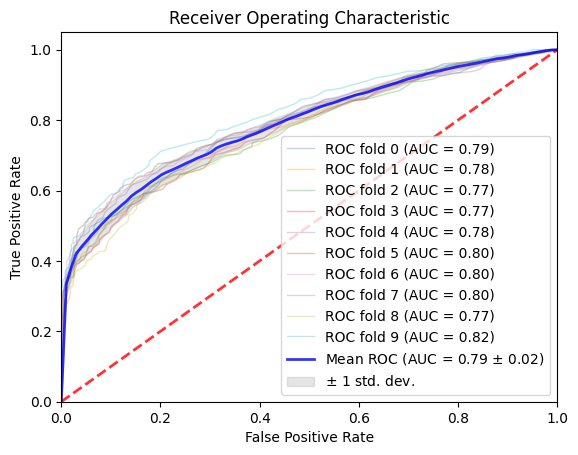

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.72      0.84      0.78      1409
           1       0.80      0.65      0.72      1340

    accuracy                           0.75      2749
   macro avg       0.76      0.75      0.75      2749
weighted avg       0.76      0.75      0.75      2749



In [1]:
import numpy as np
import scipy.io as sio
from scipy.stats import kurtosis, skew
from scipy.signal import welch
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, roc_curve, auc, make_scorer
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Reshape, LSTM
import optuna
import pywt
from xgboost import XGBClassifier  # Make sure to import XGBClassifier

# Load the data
file_path = 'C:\\Users\\UC\\Documents\\NeuMa\\22117124\\new.mat'
new = sio.loadmat(file_path)
Label = new['label_list'].flatten()
EEG = new['EEG']

# Feature extraction for ML
def extract_ml_features(data):
    features = []
    for i in range(data.shape[2]):  # Iterate over samples
        sample = data[:, :, i]
        sample_features = []
        for j in range(data.shape[0]):  # Iterate over channels
            channel_data = sample[j, :]
            # Statistical features
            mean = np.mean(channel_data)
            var = np.var(channel_data)
            skewness = skew(channel_data)
            kurt = kurtosis(channel_data)
            # Frequency domain features using Welch's method
            freqs, psd = welch(channel_data)
            psd_mean = np.mean(psd)
            psd_std = np.std(psd)
            # Combine all features
            sample_features.extend([mean, var, skewness, kurt, psd_mean, psd_std])
        features.append(sample_features)
    return np.array(features)

# Wavelet transform features
def extract_wavelet_features(data):
    features = []
    for i in range(data.shape[2]):  # Iterate over samples
        sample = data[:, :, i]
        sample_features = []
        for j in range(data.shape[0]):  # Iterate over channels
            channel_data = sample[j, :]
            coeffs = pywt.wavedec(channel_data, 'db4', level=4)
            for coeff in coeffs:
                sample_features.extend([np.mean(coeff), np.std(coeff)])
        features.append(sample_features)
    return np.array(features)

ml_features = extract_ml_features(EEG)
wavelet_features = extract_wavelet_features(EEG)
ml_features = np.concatenate((ml_features, wavelet_features), axis=1)

# Feature extraction for DL using CNN and LSTM
input_shape = (EEG.shape[0], EEG.shape[1], 1)

input_layer = Input(shape=input_shape)
conv1 = Conv2D(32, (3, 3), activation='relu')(input_layer)
pool1 = MaxPooling2D((2, 2))(conv1)
conv2 = Conv2D(64, (3, 3), activation='relu')(pool1)
pool2 = MaxPooling2D((2, 2))(conv2)
flatten = Flatten()(pool2)

# Reshape for LSTM layer
reshape_layer = Reshape((flatten.shape[1], 1))(flatten)
lstm_layer = LSTM(64)(reshape_layer)
dense1 = Dense(128, activation='relu')(lstm_layer)
output_layer = Dense(64, activation='relu')(dense1)  # Output for feature extraction

cnn_rnn_model = Model(inputs=input_layer, outputs=output_layer)
cnn_rnn_model.compile(optimizer='adam', loss='mse')

# Reshape data for CNN input
data_cnn = EEG.reshape(EEG.shape[2], EEG.shape[0], EEG.shape[1], 1)

cnn_rnn_features = cnn_rnn_model.predict(data_cnn)

# Combine ML and DL features
combined_features = np.concatenate((ml_features, cnn_rnn_features), axis=1)

# Handle imbalanced data using SMOTE
smote = SMOTE()
combined_features_resampled, labels_resampled = smote.fit_resample(combined_features, Label)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(combined_features_resampled, labels_resampled, test_size=0.2, random_state=42)

# Best parameters found by Optuna
best_params = {'rf_n_estimators': 265, 'gb_n_estimators': 89, 'xgb_n_estimators': 300}

rf_clf = RandomForestClassifier(n_estimators=best_params['rf_n_estimators'])
gb_clf = GradientBoostingClassifier(n_estimators=best_params['gb_n_estimators'])
xgb_clf = XGBClassifier(n_estimators=best_params['xgb_n_estimators'])

stacking_clf = StackingClassifier(estimators=[
    ('rf', rf_clf), 
    ('gb', gb_clf),
    ('xgb', xgb_clf)
], final_estimator=RandomForestClassifier(n_estimators=100))

# Cross-validation
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
y_test_proba = []

fig, ax = plt.subplots()

for i, (train_index, val_index) in enumerate(kf.split(X_train, y_train)):
    X_train_cv, X_val_cv = X_train[train_index], X_train[val_index]
    y_train_cv, y_val_cv = y_train[train_index], y_train[val_index]
    
    stacking_clf.fit(X_train_cv, y_train_cv)
    y_pred_proba_cv = stacking_clf.predict_proba(X_val_cv)[:, 1]
    
    # Collect the probabilities for the test set
    if i == 0:
        y_test_proba = stacking_clf.predict_proba(X_test)[:, 1]
    else:
        y_test_proba += stacking_clf.predict_proba(X_test)[:, 1]
    
    fpr, tpr, _ = roc_curve(y_val_cv, y_pred_proba_cv)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc_cv = auc(fpr, tpr)
    aucs.append(roc_auc_cv)
    
    ax.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc_cv))

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=0.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[0, 1], ylim=[0, 1.05],
       xlabel='False Positive Rate',
       ylabel='True Positive Rate',
       title='Receiver Operating Characteristic')
ax.legend(loc="lower right")
plt.show()

# Average the probabilities for the test set
y_test_proba /= kf.get_n_splits()

# Predict the final labels based on the average probabilities
y_test_pred = (y_test_proba > 0.5).astype(int)

# Print the classification report
print("Classification Report on Test Set:")
print(classification_report(y_test, y_test_pred))


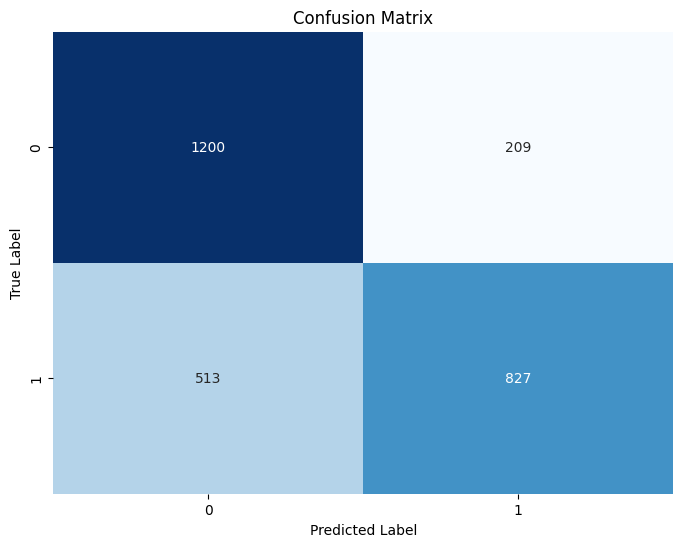

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


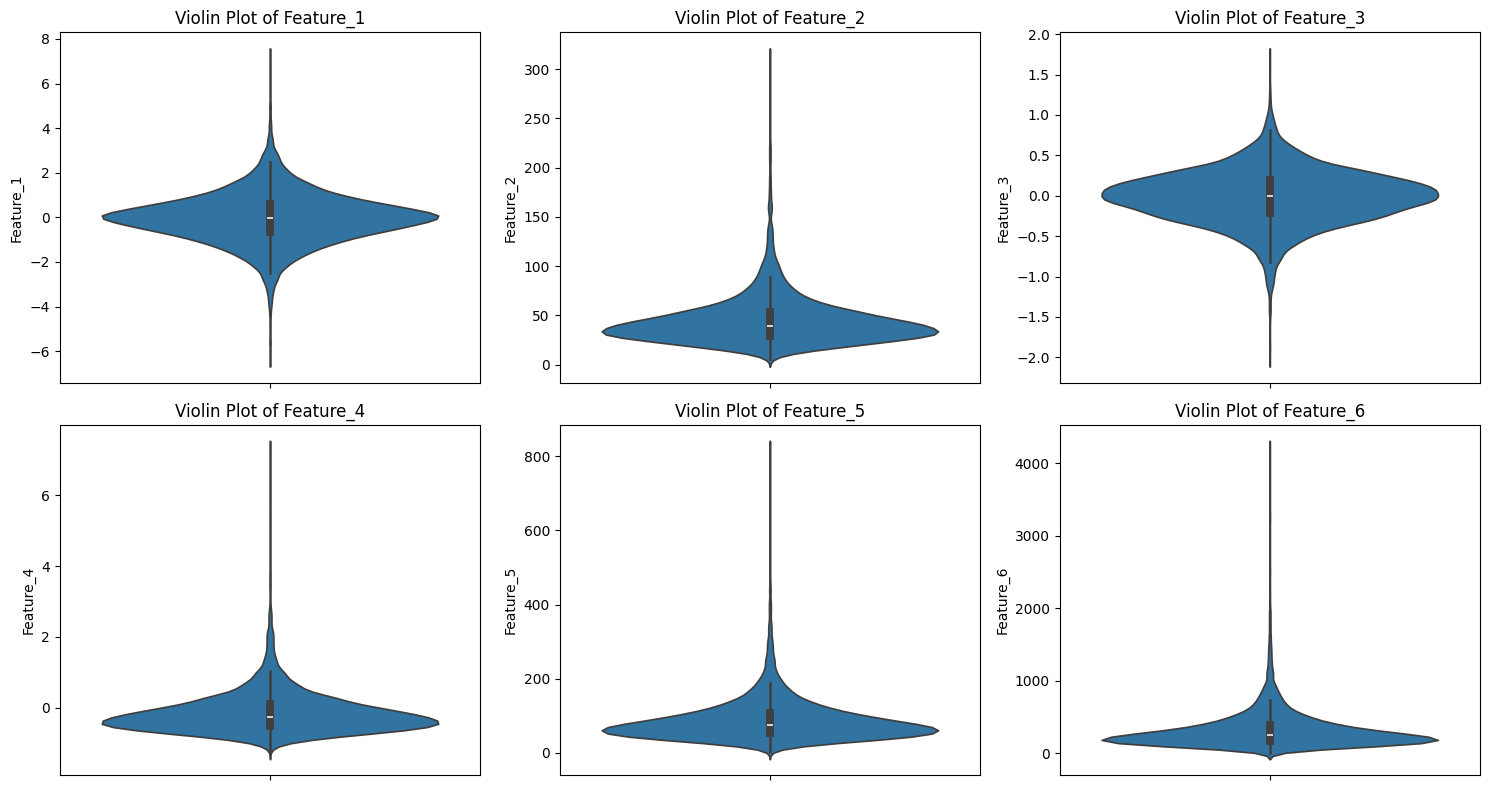

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert combined features to a DataFrame for easier plotting
num_features = combined_features.shape[1]
feature_names = [f'Feature_{i+1}' for i in range(num_features)]
combined_features_df = pd.DataFrame(combined_features, columns=feature_names)

# Plot violin plots for the first few features
num_features_to_plot = 6  # Adjust this to plot more or fewer features

plt.figure(figsize=(15, 8))
for i in range(num_features_to_plot):
    plt.subplot(2, (num_features_to_plot + 1) // 2, i + 1)
    sns.violinplot(y=combined_features_df.iloc[:, i])
    plt.title(f'Violin Plot of {feature_names[i]}')
plt.tight_layout()
plt.show()


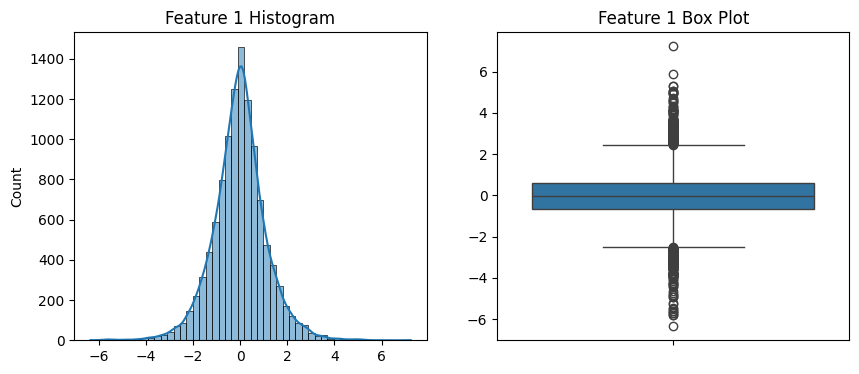

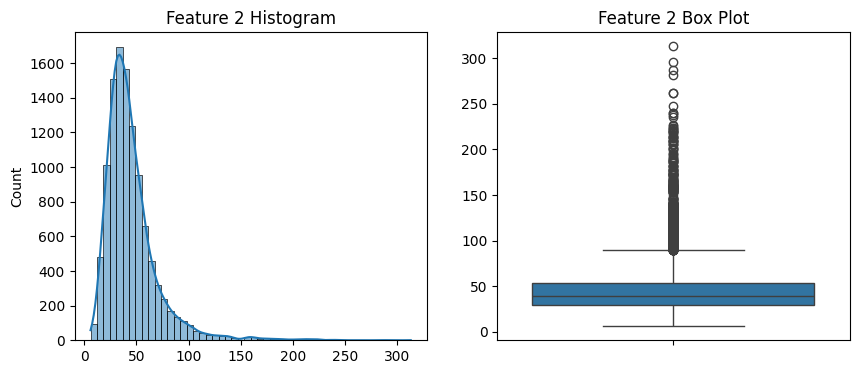

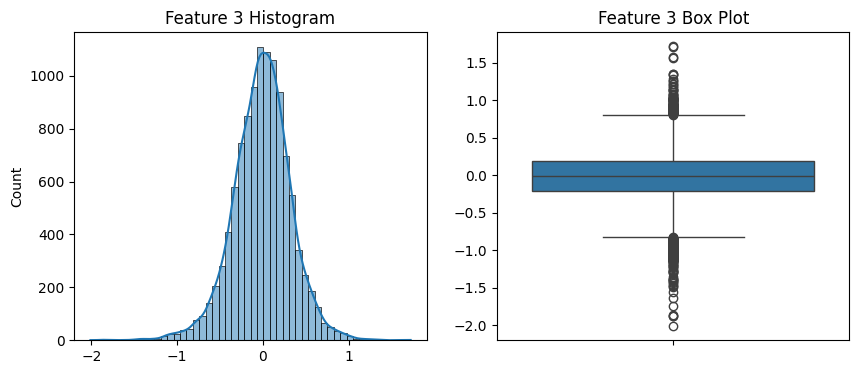

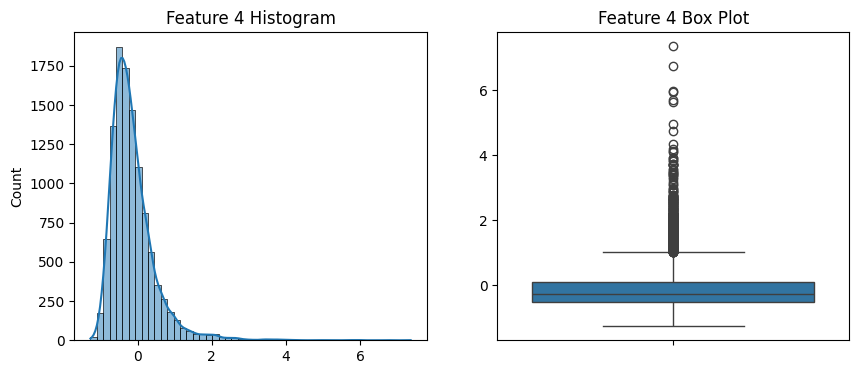

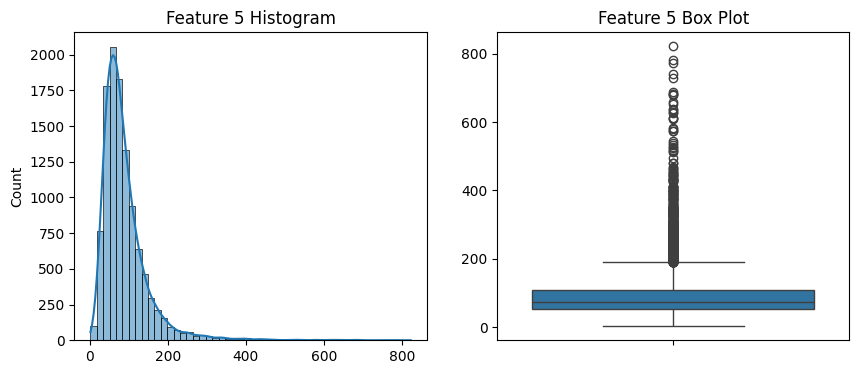

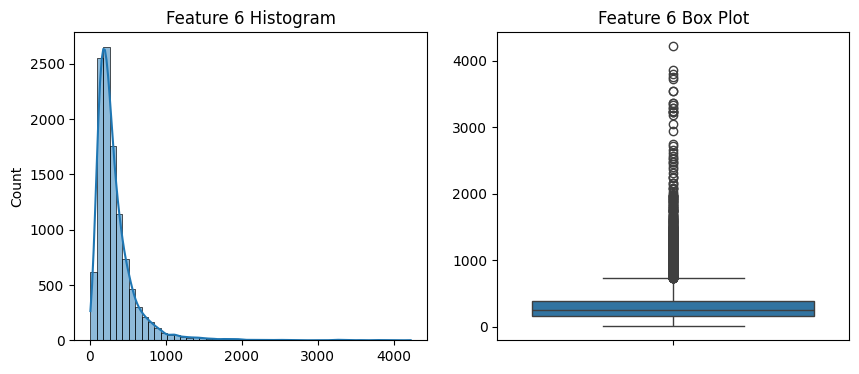

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the distribution of the first few features
for i in range(6):  # Adjust the range for the number of features you want to visualize
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    sns.histplot(combined_features[:, i], bins=50, kde=True)
    plt.title(f'Feature {i+1} Histogram')
    
    plt.subplot(1, 2, 2)
    sns.boxplot(y=combined_features[:, i])
    plt.title(f'Feature {i+1} Box Plot')
    
    plt.show()


In [19]:
cnn_rnn_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 19, 300, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 17, 298, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 149, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 147, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 73, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 14016)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 14016, 1)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,288 (204.25 KB)

 Trainable params: 52,288 (204.25 KB)

 Non-trainable params: 0 (0.00 B)

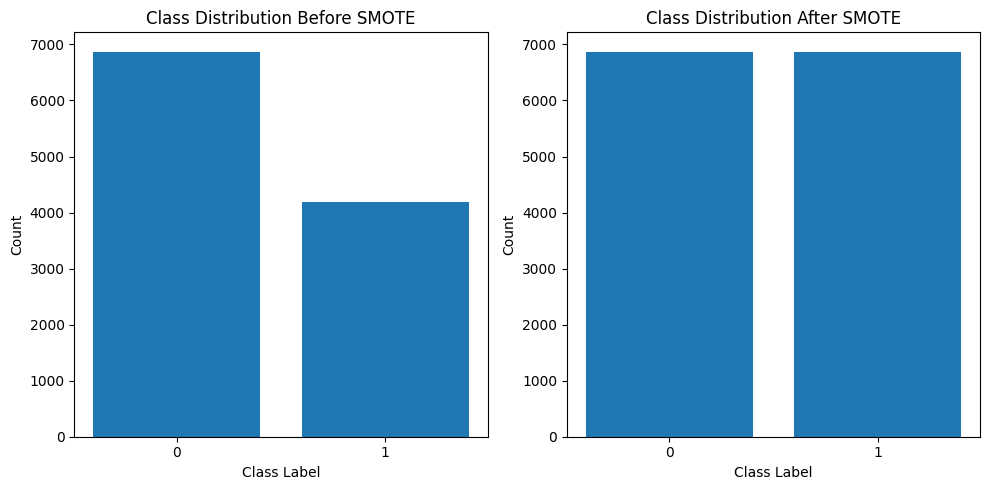

In [20]:
import matplotlib.pyplot as plt

# Plot class distribution before SMOTE
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(np.unique(Label), np.bincount(Label))
plt.title('Class Distribution Before SMOTE')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.xticks(np.unique(Label))

# Plot class distribution after SMOTE
plt.subplot(1, 2, 2)
plt.bar(np.unique(labels_resampled), np.bincount(labels_resampled))
plt.title('Class Distribution After SMOTE')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.xticks(np.unique(labels_resampled))

plt.tight_layout()
plt.show()


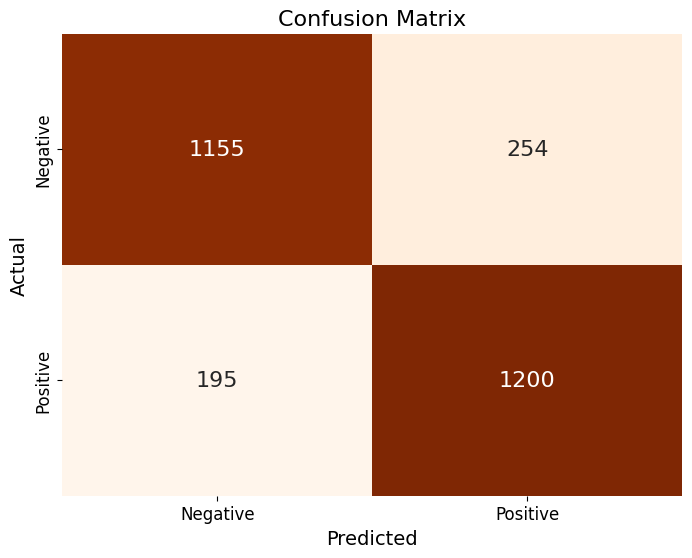

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Given values
TP = 1200
TN = 1155
FP = 254
FN = 195
# Constructing the confusion matrix
conf_matrix = np.array([[TN, FP], [FN, TP]])

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Oranges", cbar=False, annot_kws={"size": 16})

plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.xticks([0.5, 1.5], ['Negative', 'Positive'], fontsize=12)
plt.yticks([0.5, 1.5], ['Negative', 'Positive'], fontsize=12)
plt.show()


In [18]:
combined_features.shape, ml_features.shape, cnn_rnn_features.shape, wavelet_features.shape,

((11068, 368), (11068, 304), (11068, 64), (11068, 190))

In [13]:
coeffs.shape

NameError: name 'coeffs' is not defined